# LSTM for Time Series Analysis

We will use the **LSTM RNN** for forecasting Bitcoin trade data. We take in sequence of previous data with all dimensions and predict the *High* value. 

In [1]:
import sklearn.preprocessing as sk

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import sampler
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
print(torch.cuda.is_available())

True


First read the data and preview

In [2]:
training_set = pd.read_csv('../data/gemini_BTCUSD_day.csv')
training_set.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1642737600000,2022-01-21 04:00:00,BTCUSD,38462.49,39289.82,35389.69,36356.59,3462.668751
1,1642651200000,2022-01-20 04:00:00,BTCUSD,41954.50,43516.85,38260.00,38462.49,2551.473106
2,1642564800000,2022-01-19 04:00:00,BTCUSD,41712.63,42580.05,41156.28,41954.50,1214.411904
3,1642478400000,2022-01-18 04:00:00,BTCUSD,42052.76,42679.80,41281.06,41712.63,1130.901551
4,1642392000000,2022-01-17 04:00:00,BTCUSD,42655.12,42976.61,41559.11,42052.76,636.137418


## Pre-processing the data

In [3]:
training_set = training_set[['Open', 'High', 'Low', 'Close','Volume']]

# Appropriate scaling to avoid large values
x_scaler = sk.MinMaxScaler(feature_range = (0, 1))
y_scaler = sk.MinMaxScaler(feature_range = (0, 1))

# Transforming into standardized data
x_data = x_scaler.fit_transform(training_set)
y_data = y_scaler.fit_transform(training_set[['High']])

training_set.head()

,Open,High,Low,Close,Volume
0,38462.49,39289.82,35389.69,36356.59,3462.668751
1,41954.50,43516.85,38260.00,38462.49,2551.473106
2,41712.63,42580.05,41156.28,41954.50,1214.411904
3,42052.76,42679.80,41281.06,41712.63,1130.901551
4,42655.12,42976.61,41559.11,42052.76,636.137418


We define our own `Dataset` for convenience

In [4]:
class MyDset(Dataset):

    def __init__(self, data, target, window, future=0):
        x_vals = []
        y_vals = []
        start = 0 + window 
        end = len(data) - future

        for i in range(start, end):
            x = data[(i-window):i,:]
            y = target[i:(i+future),:]
            x_vals.append(x)
            y_vals.append(y)

        tensor_x = torch.Tensor(x_vals)
        tensor_y = torch.Tensor(y_vals)

        self.data = tensor_x
        self.target = tensor_y.flatten(1)
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

We create the `Dataloader` objects. We will reserve the `loader_test` for later.

In [56]:
future = 1
window = 100
set_train = MyDset(x_data, y_data, window=window, future = future)
batch_size = 20
train_split = int(0.8*(len(set_train)))

loader_train = DataLoader(set_train, batch_size = batch_size,\
   sampler=sampler.SubsetRandomSampler(range(train_split)))
   
loader_test = DataLoader(set_train, batch_size = batch_size,\
   sampler=sampler.SubsetRandomSampler(range(train_split, len(set_train))))

Debugging

In [57]:
for t, (x,y) in enumerate(loader_test):
    print(x.shape)
    print(y[0])
    break

torch.Size([20, 100, 5])
tensor([0.0012])


## Implementing the model

We use **LSTM** recurrent neural network with a fully connected layer.

In [9]:
class RNN(nn.Module):
    '''Implement the LSTM model for forecasting.'''
    def __init__(self, input_size, hidden_size, \
        num_layer, num_class = 1):

        super(RNN, self).__init__()

        self.device = device
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layer = num_layer
        self.num_class = num_class

        self.lstm = nn.LSTM(input_size, hidden_size, num_layer, \
            batch_first = True) # initial hidden and cell state default 0

        self.fc = nn.Linear(hidden_size, num_class)

    def forward(self, input):


        # # Hidden state
        h0 = torch.zeros(self.num_layer, x.size(0), self.hidden_size).requires_grad_().to(self.device)

        # # Cell state
        c0 = torch.zeros(self.num_layer, x.size(0), self.hidden_size).requires_grad_().to(self.device)
        
        _ , (h_out, _) = self.lstm(input, (h0.detach(), c0.detach())) # output of LSTM is out,(hidden,cell)

        output = h_out[0] # reshape to use linear for prediction

        output = self.fc(output)

        # output = F.tanh(output)

        return output

Testing and debugging

In [74]:
x = torch.zeros([20,100,5]).to(device)
input_size = 5
hidden_size = 16
num_layer = 5
num_class = future

model = RNN(input_size, hidden_size, num_layer, num_class)
model.to(device)
model(x).shape

torch.Size([20, 1])

# Training

We train with *mean squared error* loss and optimizer *Adam*

In [87]:
input_size = 5
hidden_size = 5
num_layer = 15
num_class = future 
model = RNN(input_size, hidden_size, num_layer, num_class)
model.to(device)

learning_rate = 1e-3
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 50

We actually observe some great fluctuations in training loss that have been masked by the scaling

Epoch 0 Iteration 0, loss = 0.15619139
0
Epoch 1 Iteration 0, loss = 0.06816739
0
Epoch 2 Iteration 0, loss = 0.04186062
0
Epoch 3 Iteration 0, loss = 0.00899936
0
Epoch 4 Iteration 0, loss = 0.01256592
0
Epoch 5 Iteration 0, loss = 0.01286588
0
Epoch 6 Iteration 0, loss = 0.00770229
0
Epoch 7 Iteration 0, loss = 0.00649118
0
Epoch 8 Iteration 0, loss = 0.01246574
0
Epoch 9 Iteration 0, loss = 0.00490084
0
Epoch 10 Iteration 0, loss = 0.00563922
0
Epoch 11 Iteration 0, loss = 0.00425771
0
Epoch 12 Iteration 0, loss = 0.00625242
0
Epoch 13 Iteration 0, loss = 0.00578608
0
Epoch 14 Iteration 0, loss = 0.01499867
0
Epoch 15 Iteration 0, loss = 0.00916197
0
Epoch 16 Iteration 0, loss = 0.01207839
0
Epoch 17 Iteration 0, loss = 0.01087852
0
Epoch 18 Iteration 0, loss = 0.00587316
0
Epoch 19 Iteration 0, loss = 0.00409589
0
Epoch 20 Iteration 0, loss = 0.00766573
0
Epoch 21 Iteration 0, loss = 0.01144217
0
Epoch 22 Iteration 0, loss = 0.00751547
0
Epoch 23 Iteration 0, loss = 0.00903048
0
Ep

Text(0.5, 1.0, 'Training Loss')

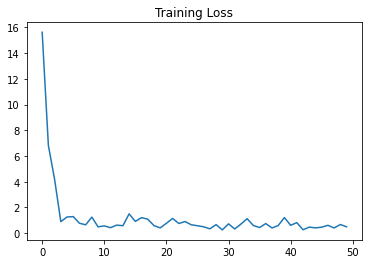

In [88]:
_loss = []
loss_plot = []

print_every = 100
for e in range(epochs):

    for t, (x,y) in enumerate(loader_train):

        model.train()  # put model to training mode

        x = x.to(device=device, dtype=torch.float32)
        y = y.to(device=device, dtype=torch.float32)

        scores = model(x)
        
        loss = criterion(scores, y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if t % print_every == 0:
            print('Epoch %d Iteration %d, loss = %.8f' % (e, t, loss.item()))
            _loss.append(loss)
            print(t)

    torch.save(model.state_dict(), 'LSTM.ckpt')
for loss in _loss:
    loss = loss.to('cpu')
    loss = loss.item()*100
    loss_plot.append(loss)
    
# print(loss_plot)
plt.plot(loss_plot)
plt.title("Training Loss")

# Testing

We examine the *loss* on unseen part of the data and evaluate the model's performance in a handwavy way

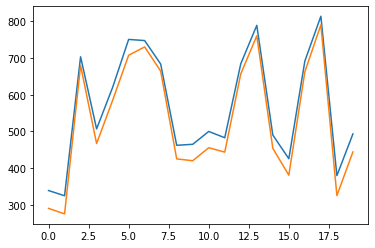

In [89]:
epochs = 1

true_y = None
prev_x = None
pred_y = None

for e in range(epochs):
    for t, (x,y) in enumerate(loader_test):
        with torch.no_grad():
            
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.float32)
            
            pred_y = model(x).to('cpu')

            prev_x = x.to('cpu')
            true_y = y.to('cpu')

            break

# fig, axs = plt.subplots(2)
# axs[0].plot(y_scaler.inverse_transform(pred_y))
# axs[1].plot(y_scaler.inverse_transform(true_y))

plt.plot(y_scaler.inverse_transform(pred_y))
plt.plot(y_scaler.inverse_transform(true_y))


We provide an example to visualize this

In [110]:
# predicted = y_scaler.inverse_transform(predicted)
# with torch.no_grad():
#     predicted = y_scaler.inverse_transform(predicted)[0]
#     test_y = y_scaler.inverse_transform(test_y)[0]

# plt.figure(figsize=(10,5))
# plt.plot(predicted)


torch.Size([20, 50])


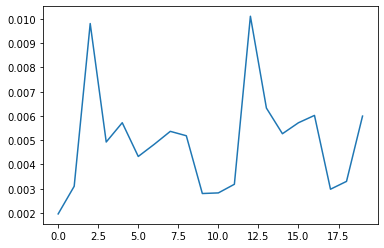

In [98]:
# test_y = y_scaler.inverse_transform(test_y)

plt.plot(test_y)

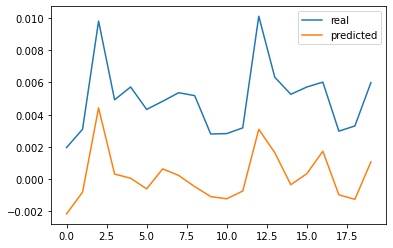

In [99]:
plt.plot(test_y, label="real")
plt.plot(predicted, label="predicted")
plt.legend()


In [100]:
input_size = 5
hidden_size = 10
num_layer = 1
num_class = future
model = RNN(input_size, hidden_size, num_layer, num_class)

model.load_state_dict(torch.load("..\src\LSTM.ckpt"))

<All keys matched successfully>